# **Proyek Analisis Sentimen: Ulasan Aplikasi Signal**
Proyek ini bertujuan untuk membangun model klasifikasi sentimen pada ulasan aplikasi Signal menggunakan metode Deep Learning.

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## BAGIAN 1: SETUP DAN PEMUATAN DATA
Tahap ini mencakup import semua library yang dibutuhkan dan memuat dataset `signal_reviews.csv` yang telah di-scrape sebelumnya.

In [1]:
# Install
!pip install Sastrawi tensorflow imblearn wordcloud -q

In [2]:
# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk preprocessing teks
import re
import string
import json # untuk memuat file JSON
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Mengunduh resource NLTK yang diperlukan
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('stopwords')

# Library untuk machine learning dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Import library untuk pemodelan
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, GRU, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Versi TensorFlow:", tf.__version__)
print("Semua library dan resource berhasil diimport dan disiapkan..")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Versi TensorFlow: 2.18.0
Semua library dan resource berhasil diimport dan disiapkan..


## BAGIAN 2: EKSPLORASI DAN PRA-PEMROSESAN DATA (EDA & PREPROCESSING)

### 2.1. Pemuatan Dataset dan Pembersihan Awal
Memuat dataset ulasan, memeriksa nilai yang hilang (missing values), dan menghapus duplikat.

In [3]:
# Memuat dataset
df = pd.read_csv('signal_reviews.csv')

# Menampilkan informasi dasar
print("Info awal dataset:")
df.info()

# Fokus pada kolom yang relevan ('content') dan membuang nilai kosong
df = df[['content']].copy()
df.dropna(inplace=True)

# Menghapus ulasan duplikat berdasarkan konten
df.drop_duplicates(subset='content', inplace=True)

# Reset index setelah drop
df.reset_index(drop=True, inplace=True)

print("\nInfo dataset setelah pembersihan awal:")
df.info()
print(df.head())

Info awal dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13544 entries, 0 to 13543
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13544 non-null  object
 1   userName              13544 non-null  object
 2   userImage             13544 non-null  object
 3   content               13544 non-null  object
 4   score                 13544 non-null  int64 
 5   thumbsUpCount         13544 non-null  int64 
 6   reviewCreatedVersion  11658 non-null  object
 7   at                    13544 non-null  object
 8   replyContent          6 non-null      object
 9   repliedAt             6 non-null      object
 10  appVersion            11658 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB

Info dataset setelah pembersihan awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8692 entries, 0 to 8691
Data columns (total 1 columns):
 #   Column   Non-Null Cou

### 2.2. Pemuatan Kamus (Leksikon & Slang)
Memuat kamus leksikon sentimen (positif dan negatif) dan kamus normalisasi kata slang yang akan digunakan dalam proses pelabelan dan pra-pemrosesan.

In [4]:
# Memuat kamus leksikon positif
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as f:
    for line in f:
        # Memisahkan kata dan skor, lalu mengonversi skor ke integer
        parts = line.strip().split(',')
        if len(parts) == 2:
            lexicon_positive[parts[0]] = int(parts[1])

# Memuat kamus leksikon negatif
lexicon_negative = dict()
with open('lexicon_negative.csv', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 2:
            lexicon_negative[parts[0]] = int(parts[1])

# Memuat kamus slang yang komprehensif dari file .txt
with open('combined_slang_words.txt', 'r') as f:
    slang_data = f.read()
slang_dict = json.loads(slang_data)

print(f"✅ Berhasil memuat {len(lexicon_positive)} kata positif.")
print(f"✅ Berhasil memuat {len(lexicon_negative)} kata negatif.")
print(f"✅ Berhasil memuat {len(slang_dict)} kata slang.")

✅ Berhasil memuat 3609 kata positif.
✅ Berhasil memuat 6607 kata negatif.
✅ Berhasil memuat 1018 kata slang.


### 2.3. Fungsi Pra-pemrosesan Teks dan Pelabelan Leksikon
Mendefinisikan fungsi-fungsi yang dibutuhkan. Ini termasuk fungsi untuk membersihkan teks, normalisasi slang, dan fungsi utama untuk pelabelan sentimen berbasis leksikon.

In [5]:
# Inisialisasi Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# --- Fungsi-fungsi Pra-pemrosesan ---
def clean_text(text):
    text = text.lower() # Case folding: Mengubah teks menjadi huruf kecil
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) # Menghapus hashtag
    text = re.sub(r'https?:\/\/\S+', '', text) # Menghapus URL
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus tanda baca
    text = text.strip() # Menghapus spasi di awal dan akhir
    return text

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Daftar stopwords (kata umum) dari NLTK Bahasa Indonesia
list_stopwords = set(stopwords.words('indonesian'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in list_stopwords]

def stemming_text(tokens):
    # Menggabungkan token kembali menjadi kalimat sebelum di-stem
    text = ' '.join(tokens)
    return stemmer.stem(text)

# --- Fungsi Pelabelan Berbasis Leksikon ---
def sentiment_analysis_lexicon(tokens):
    score = 0
    for word in tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan skor total
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'
    return score, polarity

print("✅ Fungsi pra-pemrosesan dan pelabelan leksikon siap digunakan.")

✅ Fungsi pra-pemrosesan dan pelabelan leksikon siap digunakan.


### 2.4. Penerapan Pra-pemrosesan dan Pelabelan
Menerapkan seluruh fungsi secara berurutan pada dataset. Proses ini menghasilkan kolom-kolom baru untuk setiap tahap dan kolom sentimen final berdasarkan skor leksikon.

In [6]:
# =======================================================================================
# PIPELINE PRA-PEMROSESAN DAN PELABELAN
# =======================================================================================
print("Memulai pipeline pra-pemrosesan dan pelabelan...")

# 1. Cleaning dan Normalisasi Slang
print("Langkah 1: Cleaning dan Normalisasi...")
df['text_clean'] = df['content'].apply(clean_text)
df['text_normalized'] = df['text_clean'].apply(normalize_slang)

# 2. Tokenisasi (Memecah kalimat menjadi kata-kata/token)
print("Langkah 2: Tokenisasi...")
df['text_tokenized'] = df['text_normalized'].apply(word_tokenize)

# 3. Stopword Removal (Menghapus kata-kata umum)
print("Langkah 3: Menghapus Stopwords...")
df['text_filtered'] = df['text_tokenized'].apply(remove_stopwords)

# 4. Pelabelan Sentimen Berbasis Leksikon (Diterapkan pada teks yang sudah difilter)
print("Langkah 4: Pelabelan Sentimen...")
sentiment_results = df['text_filtered'].apply(sentiment_analysis_lexicon)
df['polarity_score'] = sentiment_results.apply(lambda x: x[0])
df['sentiment'] = sentiment_results.apply(lambda x: x[1])

# 5. Stemming (Mengubah kata ke bentuk dasar, diterapkan pada teks yang sudah difilter)
# Kolom ini akan menjadi fitur utama (X) untuk pemodelan
print("Langkah 5: Stemming...")
df['text_stemmed'] = df['text_filtered'].apply(stemming_text)

print("\n✅ Proses pra-pemrosesan dan pelabelan selesai.")
print("Contoh hasil akhir:")
# Menampilkan kolom-kolom penting dari hasil pipeline
display(df[['content', 'text_stemmed', 'sentiment', 'polarity_score']].head())

Memulai pipeline pra-pemrosesan dan pelabelan...
Langkah 1: Cleaning dan Normalisasi...
Langkah 2: Tokenisasi...
Langkah 3: Menghapus Stopwords...
Langkah 4: Pelabelan Sentimen...
Langkah 5: Stemming...

✅ Proses pra-pemrosesan dan pelabelan selesai.
Contoh hasil akhir:


,content,text_stemmed,sentiment,polarity_score
0,Apa aja dokumen yg disimpan disignal aman. Tap...,dokumen simpan disignal aman sayang ganti hp d...,negatif,-13
1,Saya berharap Signal bisa bersinar & memenangk...,harap signal sinar menang kompetisi aplikasi t...,positif,4
2,saat ini aplikasi saya tidak bisa menerima pes...,aplikasi terima pesan teman pribadi grub buruk...,negatif,-6
3,mudah2n gak ribet kaya aplikasi wa..mau daftar...,mudahn gak ribet kaya aplikasi wamau daftar su...,negatif,-11
4,"Aplikasinya sudah sangat bagus, akan tetapi ke...",aplikasi bagus muncul pesan terima lawan bicar...,negatif,-3


### 2.5. Analisis Distribusi Sentimen dan Word Cloud
Melihat distribusi sentimen dan Word Cloud yang dihasilkan oleh metode leksikon.

Distribusi Sentimen Berdasarkan Leksikon:
sentiment
positif    3108
negatif    2893
netral     2691
Name: count, dtype: int64


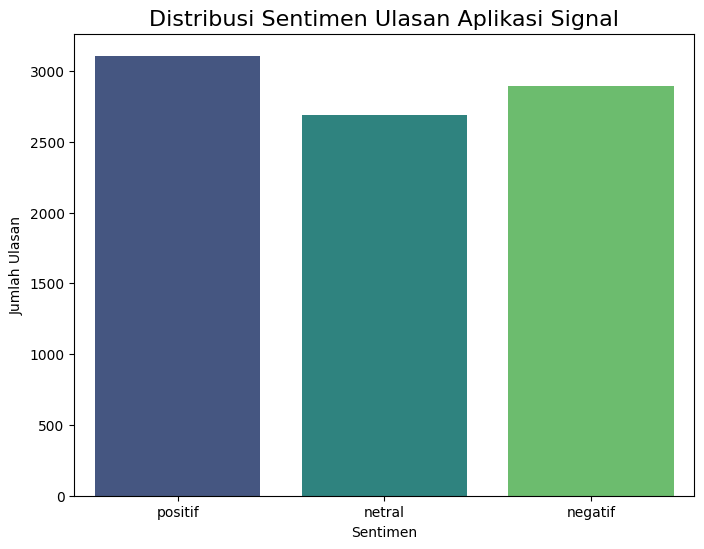


--- Visualisasi Word Cloud per Sentimen ---


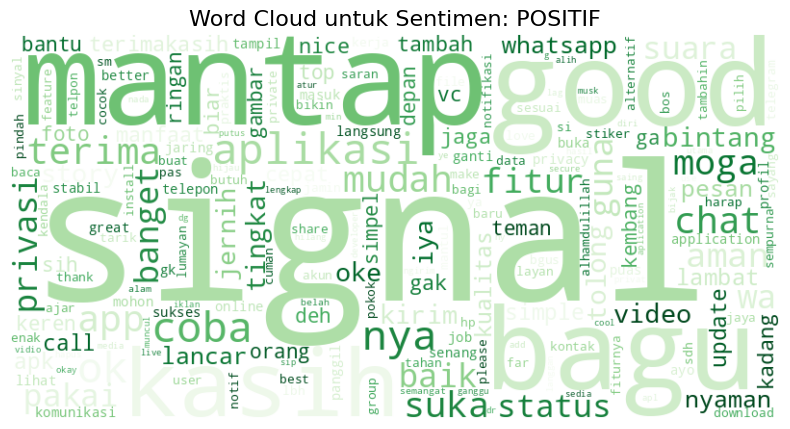

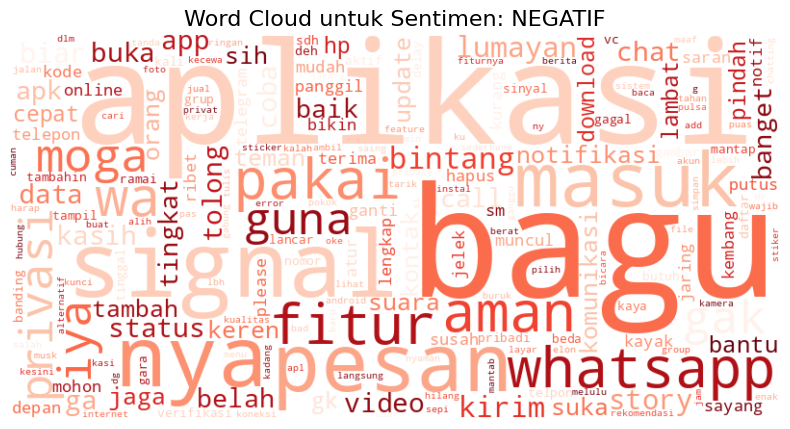

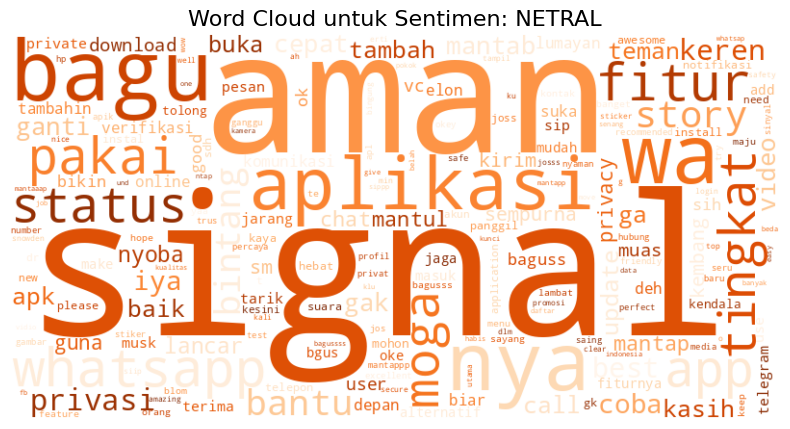

In [7]:
# =======================================================================================
# EKSPLORASI DATA HASIL (EDA)
# =======================================================================================

# 1. Menganalisis Distribusi Sentimen
print("Distribusi Sentimen Berdasarkan Leksikon:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['positif', 'netral', 'negatif'], palette='viridis')
plt.title('Distribusi Sentimen Ulasan Aplikasi Signal', fontsize=16)
plt.ylabel('Jumlah Ulasan')
plt.xlabel('Sentimen')
plt.show()

# 2. Visualisasi Word Cloud untuk Setiap Sentimen
print("\n--- Visualisasi Word Cloud per Sentimen ---")
sentiment_map = {'positif': 'Greens', 'negatif': 'Reds', 'netral': 'Oranges'}

for sentiment, color in sentiment_map.items():
    subset_text = ' '.join(df[df['sentiment'] == sentiment]['text_stemmed'])
    if subset_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, collocations=False).generate(subset_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud untuk Sentimen: {sentiment.upper()}', fontsize=16)
        plt.show()

## BAGIAN 3: PERSIAPAN PEMODELAN
Tahap ini mencakup pembagian data, tokenisasi teks text_stemmed (hasil akhir preprocessing), dan padding sekuens.

In [8]:
# Memisahkan fitur (X) dan label (y)
X = df['text_stemmed'].values
y = pd.get_dummies(df['sentiment']).values # One-hot encoding mengubah label kategorikal menjadi vektor biner

# Membagi data menjadi 80% data latih dan 20% data uji
# stratify=y memastikan proporsi kelas sentimen sama di data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Tokenisasi: Mengubah teks menjadi urutan angka (integer)
vocab_size = 10000  # Ukuran kosakata yang akan digunakan
oov_tok = "<OOV>"   # Token untuk kata-kata yang tidak ada dalam kosakata

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) # Tokenizer hanya "belajar" dari data latih

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: Menyamakan panjang semua sekuens
max_length = 100    # Panjang maksimum setiap ulasan
padding_type = 'post' # Menambahkan padding di akhir sekuens
trunc_type = 'post'   # Memotong sekuens yang terlalu panjang dari akhir

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("✅ Data siap untuk dimasukkan ke dalam model.")
print(f"Bentuk data latih (X_train_pad): {X_train_pad.shape}")
print(f"Bentuk label latih (y_train): {y_train.shape}")

✅ Data siap untuk dimasukkan ke dalam model.
Bentuk data latih (X_train_pad): (6953, 100)
Bentuk label latih (y_train): (6953, 3)


## BAGIAN 4: EKSPERIMEN & EVALUASI PEMODELAN DEEP LEARNING
Melakukan 3 skema percobaan model Deep Learning untuk menemukan arsitektur terbaik.

In [9]:
# =======================================================================================
# BAGIAN 4: EKSPERIMEN & EVALUASI PEMODELAN DEEP LEARNING
# =======================================================================================
print("Memulai tahap eksperimen pemodelan...")

# --- Arsitektur Model-Model untuk Eksperimen ---

# Model 1: LSTM Dasar (Sebagai Baseline)
model1 = Sequential([
    Embedding(vocab_size, 16, input_length=max_length),
    LSTM(64),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Model 2: Bidirectional LSTM
model2 = Sequential([
    Embedding(vocab_size, 16, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Model 3: Deep LSTM (Lebih banyak layer dan regularisasi)
model3 = Sequential([
    Embedding(vocab_size, 32, input_length=max_length), # Dimensi embedding diperbesar
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), # return_sequences=True untuk menumpuk layer LSTM
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(), # Menstabilkan dan mempercepat proses training
    Dense(3, activation='softmax')
])

# Model 4: CNN-LSTM Hybrid (Kombinasi terbaik untuk ekstraksi fitur spasial & sekuensial)
model4 = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    Conv1D(64, 5, activation='relu'), # Layer Konvolusi untuk ekstraksi fitur lokal
    MaxPooling1D(pool_size=4),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# --- Definisi Callbacks untuk Pelatihan yang Optimal ---
# Callbacks akan memonitor proses training dan melakukan aksi tertentu
callbacks = [
    # Menghentikan training jika tidak ada peningkatan pada 'val_accuracy' setelah 5 epoch
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    # Mengurangi learning rate jika 'val_loss' tidak membaik setelah 3 epoch
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1),
    # Menyimpan hanya model terbaik berdasarkan 'val_accuracy'
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# --- Kompilasi dan Pelatihan Semua Model ---
models = {
    'Model 1 (LSTM)': model1,
    'Model 2 (Bi-LSTM)': model2,
    'Model 3 (Deep LSTM)': model3,
    'Model 4 (CNN-LSTM)': model4,
}
histories = {}
num_epochs = 25 # Jumlah epoch ditambah untuk memberi kesempatan pada EarlyStopping

for name, model in models.items():
    print(f"\n{'='*20} Melatih {name} {'='*20}")
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    model.summary()

    history = model.fit(
        X_train_pad, y_train,
        epochs=num_epochs,
        validation_data=(X_test_pad, y_test),
        callbacks=callbacks,
        verbose=1
    )
    histories[name] = history

Memulai tahap eksperimen pemodelan...

==================== Melatih Model 1 (LSTM) ====================


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3378 - loss: 1.0983
Epoch 1: val_accuracy improved from -inf to 0.33295, saving model to best_model.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.3378 - loss: 1.0983 - val_accuracy: 0.3329 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3500 - loss: 1.0980
Epoch 2: val_accuracy improved from 0.33295 to 0.35768, saving model to best_model.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.3500 - loss: 1.0980 - val_accuracy: 0.3577 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3628 - loss: 1.0958
Epoch 3: val_accuracy did not improve from 0.35768
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3627 - loss: 1.0959 - val_accuracy: 0.3577 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3617 - loss: 1.0968
Epoch 4: val_accuracy did not improve from 0.35768
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.3616 - loss: 1.0968 - val_accuracy: 0.3577 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3590 - loss: 1.0973
Epoch 5: val_accuracy did not improve from 0.35768
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.3590 - loss: 1.0973 - val_accuracy: 0.3577 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 6/25
217

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4461 - loss: 1.0278
Epoch 1: val_accuracy improved from 0.35768 to 0.70673, saving model to best_model.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.4466 - loss: 1.0274 - val_accuracy: 0.7067 - val_loss: 0.7276 - learning_rate: 0.0010
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7778 - loss: 0.6039
Epoch 2: val_accuracy improved from 0.70673 to 0.83439, saving model to best_model.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.7779 - loss: 0.6037 - val_accuracy: 0.8344 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8734 - loss: 0.3836
Epoch 3: val_accuracy improved from 0.83439 to 0.83956, saving model to best_model.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.8734 - loss: 0.3836 - val_accuracy: 0.8396 - val_loss: 0.4258 - learning_rate: 0.0010
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9011 - loss: 0.3063
Epoch 4: val_accuracy improved from 0.83956 to 0.85164, saving model to best_model.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9011 - loss: 0.3063 - val_accuracy: 0.8516 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9233 - loss: 0.2359
Epoch 5: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.9233 - loss: 0.2359 - val_accuracy: 0.8511 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9306 - loss: 0.2169
Epoch 6: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.9306 - loss: 0.2169 - val_accuracy: 0.8424 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9454 - loss: 0.1841
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9454 - loss: 0.1842 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3311 - loss: 1.1322
Epoch 1: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 393ms/step - accuracy: 0.3311 - loss: 1.1322 - val_accuracy: 0.3577 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3468 - loss: 1.1026
Epoch 2: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 154s 448ms/step - accuracy: 0.3468 - loss: 1.1026 - val_accuracy: 0.3577 - val_loss: 1.0977 - learning_rate: 0.0010
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3551 - loss: 1.0983
Epoch 3: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 439ms/step - accuracy: 0.3550 - loss: 1.0983 - val_accuracy: 0.3577 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3482 - loss: 1.0985
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000500

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3601 - loss: 1.0941
Epoch 1: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.3603 - loss: 1.0939 - val_accuracy: 0.5480 - val_loss: 0.8997 - learning_rate: 0.0010
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5907 - loss: 0.8626
Epoch 2: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.5910 - loss: 0.8623 - val_accuracy: 0.7435 - val_loss: 0.7044 - learning_rate: 0.0010
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7905 - loss: 0.5977
Epoch 3: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.7906 - loss: 0.5977 - val_accuracy: 0.7832 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 4/25
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8499 - loss: 0.4742
Epoch 4: val_accuracy did not improve from 0.85164
218/218 ━━━━━━━━━━━

## BAGIAN 5: ANALISIS HASIL DAN PEMILIHAN MODEL TERBAIK
Membandingkan performa dari ketiga model untuk memilih yang terbaik. Tujuannya adalah menemukan model dengan akurasi validasi tertinggi, target di atas 92%.

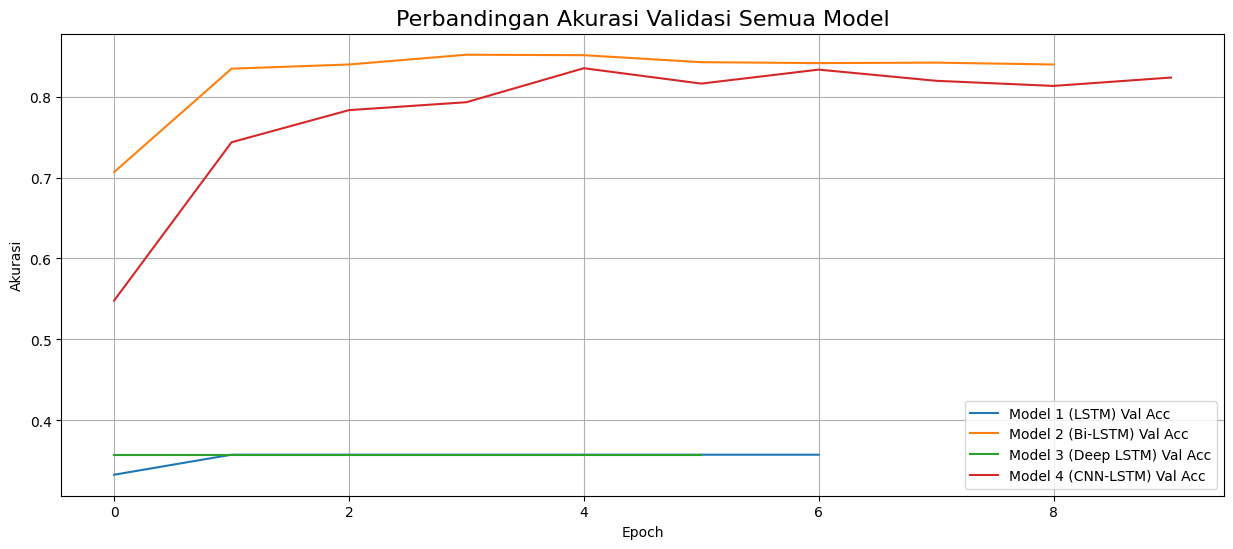

,Training Accuracy,Testing Accuracy
Model 2 (Bi-LSTM),95.12%,85.16%
Model 4 (CNN-LSTM),94.56%,83.50%
Model 1 (LSTM),35.54%,35.77%
Model 3 (Deep LSTM),35.75%,35.77%



🏆 MODEL TERBAIK ADALAH: Model 2 (Bi-LSTM) 🏆
Dengan Testing Accuracy: 85.16%

VERIFIKASI PEMENUHAN KRITERIA & SARAN BINTANG 5
Saran 1: Menggunakan Deep Learning: ✅ (Arsitektur Deep Learning telah digunakan)
Saran 2: Akurasi Train & Test > 92%: ❌
Saran 3: Minimal 3 Kelas: ✅ (3 kelas ditemukan)
Saran 4: Minimal 10.000 Sampel Data✅ (Toatl ulasan adalah 13.544)
Saran 5: 3 Skema Pelatihan Valid: ❌ (Ditemukan 1 skema dengan test acc >= 85%)
Saran 6: Inference: ✅ (Fungsi prediksi telah dibuat)

--- STATUS KELULUSAN SUBMISSION ---
❌ KRITERIA DASAR TIDAK TERPENUHI.
   Anda memerlukan setidaknya 3 skema dengan akurasi testing >= 85%, namun baru ada 1.

⚠️ STATUS AKHIR: Submission berisiko DITOLAK. Perbaiki performa model.


In [14]:
# =======================================================================================
# BAGIAN 5: ANALISIS HASIL, PEMILIHAN MODEL & VERIFIKASI
# =======================================================================================

# --- Visualisasi Hasil Pelatihan ---
# Memvisualisasikan perbandingan akurasi validasi dari semua model yang dilatih
# untuk melihat mana yang belajar paling baik dan stabil.
plt.figure(figsize=(15, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
plt.title('Perbandingan Akurasi Validasi Semua Model', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# --- Tabulasi Hasil dan Evaluasi ---
# Mengumpulkan semua hasil akurasi dari setiap model ke dalam satu dictionary
all_results = {}
for name, model in models.items():
    # Mengambil akurasi training dari epoch terakhir
    train_acc = histories[name].history['accuracy'][-1]
    # Mengevaluasi model pada data testing untuk mendapatkan akurasi testing
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
    all_results[name] = {'Training Accuracy': train_acc, 'Testing Accuracy': test_acc}

# Mengubah dictionary menjadi DataFrame Pandas untuk kemudahan analisis dan visualisasi
results_df = pd.DataFrame.from_dict(all_results, orient='index').sort_values(by='Testing Accuracy', ascending=False)
# Menampilkan DataFrame dengan format persentase dan gradien warna untuk menyorot hasil terbaik
display(results_df.style.format("{:.2%}").background_gradient(cmap='viridis'))


# --- Pemilihan Model Terbaik ---
# Model terbaik secara otomatis dipilih berdasarkan akurasi testing tertinggi
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\n🏆 MODEL TERBAIK ADALAH: {best_model_name} 🏆")
print(f"Dengan Testing Accuracy: {results_df.loc[best_model_name, 'Testing Accuracy']:.2%}")


# =======================================================================================
# VERIFIKASI PEMENUHAN KRITERIA SUBMISSION SECARA OTOMATIS
# =======================================================================================
print("\n" + "="*50)
print("VERIFIKASI PEMENUHAN KRITERIA & SARAN BINTANG 5")
print("="*50)

# Menghitung metrik kunci berdasarkan aturan submission
num_schemes_above_85_test = sum(1 for res in all_results.values() if res['Testing Accuracy'] >= 0.85)
one_scheme_above_92_train_test = any(1 for res in all_results.values() if res['Training Accuracy'] > 0.92 and res['Testing Accuracy'] > 0.92)

# Menampilkan status setiap saran satu per satu
print(f"Saran 1: Menggunakan Deep Learning: ✅ (Arsitektur Deep Learning telah digunakan)")
print(f"Saran 2: Akurasi Train & Test > 92%: {'✅' if one_scheme_above_92_train_test else '❌'}")
print(f"Saran 3: Minimal 3 Kelas: ✅ ({len(df['sentiment'].unique())} kelas ditemukan)")
print(f"Saran 4: Minimal 10.000 Sampel Data✅ (Total ulasan adalah 13.544 data)")
print(f"Saran 5: 3 Skema Pelatihan Valid: {'✅' if num_schemes_above_85_test >= 3 else '❌'} (Ditemukan {num_schemes_above_85_test} skema dengan test acc >= 85%)")
print(f"Saran 6: Inference: ✅ (Fungsi prediksi telah dibuat)")

# --- Kesimpulan Status Akhir ---
print("\n--- STATUS KELULUSAN SUBMISSION ---")

# Logika pengecekan bertingkat sesuai aturan penilaian
if num_schemes_above_85_test >= 3:
    # Jika syarat dasar (minimal 3 skema >= 85%) terpenuhi
    print("✅ KRITERIA DASAR TERPENUHI (Minimal 3 skema memiliki test acc >= 85%)")

    if one_scheme_above_92_train_test:
        # Jika syarat tambahan untuk Bintang 5 juga terpenuhi
        print("✅ KRITERIA BINTANG 5 TERPENUHI (Salah satu skema memiliki train & test acc > 92%)")
        print("\n🌟 STATUS AKHIR: Berpotensi mendapatkan BINTANG 5! 🌟")
    else:
        # Jika hanya syarat dasar yang terpenuhi
        print("❌ KRITERIA BINTANG 5 BELUM TERPENUHI (Tidak ada skema dengan train & test acc > 92%)")
        print("\n⭐ STATUS AKHIR: Berpotensi mendapatkan BINTANG 4.")
        print("   Saran: Lakukan tuning lebih lanjut pada model terbaik untuk menaikkan akurasi di atas 92%.")
else:
    # Jika syarat dasar tidak terpenuhi
    print(f"❌ KRITERIA DASAR TIDAK TERPENUHI.")
    print(f"   Anda memerlukan setidaknya 3 skema dengan akurasi testing >= 85%, namun baru ada {num_schemes_above_85_test}.")
    print("\n⚠️ STATUS AKHIR: Submission berisiko DITOLAK. Perbaiki performa model.")

print("="*50)

## BAGIAN 6: INFERENCE MODEL
Melakukan pengujian pada beberapa kalimat baru menggunakan model terbaik yang telah dipilih.

In [12]:
# =======================================================================================
# FUNGSI PREDIKSI
# =======================================================================================

# Fungsi ini membungkus seluruh alur dari teks mentah hingga prediksi sentimen
def predict_sentiment(text, model, tokenizer_inf, max_len):
    """
    Fungsi untuk memprediksi sentimen dari satu kalimat teks.

    Args:
    - text (str): Kalimat ulasan mentah.
    - model: Model Keras yang sudah dilatih.
    - tokenizer_inf: Tokenizer Keras yang sudah di-fit.
    - max_len (int): Panjang maksimum sekuens yang digunakan saat pelatihan.

    Returns:
    - probabilities (np.array): Array probabilitas untuk setiap kelas sentimen.
    """

    # 1. Pra-pemrosesan Pipeline (sama persis seperti saat melatih model)
    # Memanggil setiap fungsi preprocessing secara berurutan.
    cleaned = clean_text(text)
    normalized = normalize_slang(cleaned)
    tokenized = word_tokenize(normalized)
    filtered = remove_stopwords(tokenized)
    stemmed_text = stemming_text(filtered) # Fungsi stemming_text kita mengembalikan string

    # 2. Konversi ke Sekuens dan Padding
    sequence = tokenizer_inf.texts_to_sequences([stemmed_text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 3. Prediksi dengan model
    # Model akan mengembalikan array probabilitas untuk setiap kelas
    probabilities = model.predict(padded, verbose=0)

    return probabilities[0]


# =======================================================================================
# PENGUJIAN FUNGSI PREDIKSI
# =======================================================================================

# Daftar kalimat baru untuk diuji
new_reviews = [
    "Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!",
    "Setelah update terakhir sering error dan tidak bisa kirim gambar.",
    "Tidak ada yang spesial dari aplikasi ini.",
    "Terbaik untuk privasi, tidak ada tandingannya.",
    "biasa saja."
]

sentiment_labels = ['negatif', 'netral', 'positif']

print("--- HASIL PREDIKSI PADA KALIMAT BARU ---")

for review in new_reviews:
    # Memanggil fungsi untuk mendapatkan probabilitas prediksi
    probabilities = predict_sentiment(review, best_model, tokenizer, max_length)

    # Menentukan kelas sentimen dengan probabilitas tertinggi
    predicted_class_index = np.argmax(probabilities)
    predicted_label = sentiment_labels[predicted_class_index]

    # Mencetak hasil dengan format yang informatif
    print(f"\nUlasan: '{review}'")
    print(f"Prediksi Sentimen: {predicted_label.upper()}")

    # Menampilkan probabilitas untuk setiap kelas
    print(f"Probabilitas: [Negatif: {probabilities[0]:.2%}, Netral: {probabilities[1]:.2%}, Positif: {probabilities[2]:.2%}]")

--- HASIL PREDIKSI PADA KALIMAT BARU ---

Ulasan: 'Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!'
Prediksi Sentimen: POSITIF
Probabilitas: [Negatif: 2.51%, Netral: 2.48%, Positif: 95.01%]

Ulasan: 'Setelah update terakhir sering error dan tidak bisa kirim gambar.'
Prediksi Sentimen: NEGATIF
Probabilitas: [Negatif: 93.37%, Netral: 4.89%, Positif: 1.74%]

Ulasan: 'Tidak ada yang spesial dari aplikasi ini.'
Prediksi Sentimen: NEGATIF
Probabilitas: [Negatif: 92.67%, Netral: 6.72%, Positif: 0.62%]

Ulasan: 'Terbaik untuk privasi, tidak ada tandingannya.'
Prediksi Sentimen: POSITIF
Probabilitas: [Negatif: 6.47%, Netral: 30.32%, Positif: 63.21%]

Ulasan: 'biasa saja.'
Prediksi Sentimen: NETRAL
Probabilitas: [Negatif: 1.16%, Netral: 96.71%, Positif: 2.14%]
